# Predicting House Prices with Linear Regression
## Project Goals
In this project we will practice what we have learned about **linear regression** models. We aim to create and improve a sale price predicting model for house sales using our knowledge on model fitting, cleaning techniques, feature transformation, and feature selection.

We'll be working with housing data for Ames, Iowa from 2006 to 2010. Information of the purpose of the dataset can be found [here](https://doi.org/10.1080/10691898.2011.11889627). Information about the data contained in the dataset can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt). 

## Function Pipeline
To begin, we'll set up a pipeline of functions so that we can quickly iterate on different models and parameters.

First, we will import all of our data and tools into our environment

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

# read in our data
data = pd.read_csv("AmesHousing.tsv", delimiter = '\t')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

Here we will create a pipeline of functions to test our models. These will be updated as we progress through this project.

In [2]:
#Creating a function named `transform_features()` that, to begin, just returns the input dataframe.
# This will create our cleaned dataframe.

def transform_features(data):
    return data

# Creating a function named `select_features()` that, to begin, returns the `Gr Liv Area` and `SalePrice` columns 
# This will select our features to be used in our model.

def select_features(data):
    return data[['Gr Liv Area', 'SalePrice']]

# Creating a generic function named train_and_test() that, to begin, accepts a dataframe, splits the data to 
# 'train' and `test` sets, trains, fits, and tests the model, and returns the RMSE  value

def train_and_test(data):
    train = data[:1460]
    test = data[1460:]
    
    #select all numerical columns
    num_train = train.select_dtypes(include = ['float', 'integer'])
    num_test = test.select_dtypes(include = ['float', 'integer'])
    
    # creating a list of column names to use as features, minus the `SalePrice` column
    features = num_train.columns.drop('SalePrice')
    
    # Instantiate a LinearRegression Model
    lr = LinearRegression()
    # fit the model
    lr.fit(train[features], train['SalePrice'])
    
    # train the model
    train_predictions = lr.predict(train[features])
    # test the model
    test_predictions = lr.predict(test[features])
    
    # Calculate error as RMSE
    test_rmse = mean_squared_error(test['SalePrice'], test_predictions)**(1/2)
    
    return test_rmse

# Applying pipeline functions in sequence:
transformed_data = transform_features(data)
selected_data = select_features(transformed_data)
rmse = train_and_test(selected_data)

rmse

57088.25161263909

In the begining state state of our model, our predicted prices have an error (as RMSE) of 57088.25 dollars.

## Feature Engineering
We can now now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. 

We will begin this task by updating `transform_features()` so that:
- any column from the data frame with more than 25% missing values is dropped.
- text columns, drop any columns with a threshold of missing values
- numeric columns, drop columns with a threshold of missing values
- new features are created by combining other features
- columns that leak information about the sale (e.g. like the year the sale happened) will be dropped
- features are transformed into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)

### Missing Values

In [3]:
# where are the null values?
null_values = data.isnull().sum()
null_values

Order                0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       490
Lot Area             0
Street               0
Alley             2732
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type        23
Mas Vnr Area        23
Exter Qual           0
Exter Cond           0
                  ... 
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Fireplace Qu      1422
Garage Type        157
Garage Yr Blt      159
Garage Finish      159
Garage Cars          1
Garage Area          1
Garage Qual

In [4]:
# Filter the `null_values` series to columns containing >25% missing values
drop_missing_cols = null_values[(null_values > len(data)* .25)].sort_values()
drop_missing_cols

Fireplace Qu    1422
Fence           2358
Alley           2732
Misc Feature    2824
Pool QC         2917
dtype: int64

In [5]:
# Drop those columns (axis = 1) from the dataframe.
data = data.drop(drop_missing_cols.index, axis=1)

In [6]:
# checking number of remaining column names
#should be 5 less than the 82 listed above (77)
len(data.columns)

77

Let's see what we have for null values in our data at this point

In [7]:
null_values = data.isnull().sum()
null_values[null_values >0]

Lot Frontage      490
Mas Vnr Type       23
Mas Vnr Area       23
Bsmt Qual          80
Bsmt Cond          80
Bsmt Exposure      83
BsmtFin Type 1     80
BsmtFin SF 1        1
BsmtFin Type 2     81
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Electrical          1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Cars         1
Garage Area         1
Garage Qual       159
Garage Cond       159
dtype: int64

Columns `Mas Vnr Type` and `Mas Vnr Area` each have 23 missing values. These columns describe exterior masonary veneer area. For now, we will change these missing values to `None` and `0` respectively.


In [8]:
data['Mas Vnr Type'] = data['Mas Vnr Type'].fillna('None')
data['Mas Vnr Area'] = data['Mas Vnr Area'].fillna(0)
                                                   
# data check
null_values = data.isnull().sum()
null_values[null_values >0]

Lot Frontage      490
Bsmt Qual          80
Bsmt Cond          80
Bsmt Exposure      83
BsmtFin Type 1     80
BsmtFin SF 1        1
BsmtFin Type 2     81
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Electrical          1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Cars         1
Garage Area         1
Garage Qual       159
Garage Cond       159
dtype: int64

Let's examine the text columns with missing values:

In [9]:
text_mv = data.select_dtypes(include = ['object']).isnull().sum()
text_mv

MS Zoning           0
Street              0
Lot Shape           0
Land Contour        0
Utilities           0
Lot Config          0
Land Slope          0
Neighborhood        0
Condition 1         0
Condition 2         0
Bldg Type           0
House Style         0
Roof Style          0
Roof Matl           0
Exterior 1st        0
Exterior 2nd        0
Mas Vnr Type        0
Exter Qual          0
Exter Cond          0
Foundation          0
Bsmt Qual          80
Bsmt Cond          80
Bsmt Exposure      83
BsmtFin Type 1     80
BsmtFin Type 2     81
Heating             0
Heating QC          0
Central Air         0
Electrical          1
Kitchen Qual        0
Functional          0
Garage Type       157
Garage Finish     159
Garage Qual       159
Garage Cond       159
Paved Drive         0
Sale Type           0
Sale Condition      0
dtype: int64

For now, we will drop any columns with greater than 20 missing values. That will leave the `Electrical` column intact and we will delete the row with the missing value in this column at a later point.

In [10]:
cols_to_drop = text_mv[text_mv >20].index
data = data.drop(cols_to_drop, axis = 1)
#data check
data.select_dtypes(include = ['object']).isnull().sum()

MS Zoning         0
Street            0
Lot Shape         0
Land Contour      0
Utilities         0
Lot Config        0
Land Slope        0
Neighborhood      0
Condition 1       0
Condition 2       0
Bldg Type         0
House Style       0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type      0
Exter Qual        0
Exter Cond        0
Foundation        0
Heating           0
Heating QC        0
Central Air       0
Electrical        1
Kitchen Qual      0
Functional        0
Paved Drive       0
Sale Type         0
Sale Condition    0
dtype: int64

Next, we will examine the numeric columns with missing values:

In [11]:
data.select_dtypes(include = ['float', 'integer']).isnull().sum()

Order                0
PID                  0
MS SubClass          0
Lot Frontage       490
Lot Area             0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Mas Vnr Area         0
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       2
Bsmt Half Bath       2
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
TotRms AbvGrd        0
Fireplaces           0
Garage Yr Blt      159
Garage Cars          1
Garage Area          1
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
SalePrice            0
dtype: int64

We have two columns with high numbers of mmissing values.
`Lot Frontage` indicates the amount of linear feet of street connected to property and `Garage Yr Blt` indicates the year a garage was built. Since there's no way to determine this missing data from other data we have, we'll remove these two columns.


In [12]:
data = data.drop(data[['Lot Frontage', 'Garage Yr Blt']], axis = 1)

# data check
null_values = data.isnull().sum()
null_values[null_values >0]

BsmtFin SF 1      1
BsmtFin SF 2      1
Bsmt Unf SF       1
Total Bsmt SF     1
Electrical        1
Bsmt Full Bath    2
Bsmt Half Bath    2
Garage Cars       1
Garage Area       1
dtype: int64

Now we will remove the few rows of data with missing values.

In [13]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2926 entries, 0 to 2929
Data columns (total 66 columns):
Order              2926 non-null int64
PID                2926 non-null int64
MS SubClass        2926 non-null int64
MS Zoning          2926 non-null object
Lot Area           2926 non-null int64
Street             2926 non-null object
Lot Shape          2926 non-null object
Land Contour       2926 non-null object
Utilities          2926 non-null object
Lot Config         2926 non-null object
Land Slope         2926 non-null object
Neighborhood       2926 non-null object
Condition 1        2926 non-null object
Condition 2        2926 non-null object
Bldg Type          2926 non-null object
House Style        2926 non-null object
Overall Qual       2926 non-null int64
Overall Cond       2926 non-null int64
Year Built         2926 non-null int64
Year Remod/Add     2926 non-null int64
Roof Style         2926 non-null object
Roof Matl          2926 non-null object
Exterior 1st       29

After handling the missing values, we are left with 66 features and 2926 rows of data.

### Transforming Features
Next, we'll look into creating new features to better capture some of the existing data in some of our features.

Colunms `Yr Sold` and `Year Built` can be used to create a new column by calculating the difference between to show a  `Years_Before_Sold` metric.
Similarly, the `Yr Remod/Add` column and the `Yr Sold` column can be used to calculate a `Yr_Since_Remod` metric.

In [14]:
data['Years_Before_Sold'] = data['Yr Sold'] - data['Year Built']
data['Yr_Since_Remod'] = data['Yr Sold'] - data['Year Remod/Add']

All of these calculated values should be positive numbers so we'll check for any negative values and remove any rows of data that caclculate to a negative number

In [15]:
data[data['Years_Before_Sold'] < 0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years_Before_Sold,Yr_Since_Remod
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,17000,10,2007,New,Partial,183850,-1,-2


In [16]:
data[data['Yr_Since_Remod'] < 0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Years_Before_Sold,Yr_Since_Remod
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,6,2007,New,Partial,260116,0,-1
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,...,0,0,0,10,2007,New,Partial,184750,0,-1


In [17]:
# Remove the offending rows
data = data.drop([1702, 2180, 2181], axis = 0)

# removee the original columns
data = data.drop(['Year Built', 'Year Remod/Add' ], axis = 1)

### Removing Features
We will remove features that:
- aren't usefule to machine learning
    - `PID` is a property identification number
    - `Order` indicataes list order number
- could possible leak data about the final sale (for example, if you're making predictions on houses that are not yet sold, leaked information would be information that you wouldn't have. Those types of features wouldn't be available to you when making the prediction, they shouldn't be used to train the model.)
    - `Mo Sold`
    - `Sale Condition`
    - `Sale Type`
    - `Yr Sold`
    
We will drop these columns from our dataset.

In [18]:
data = data.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type'], axis = 1)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2923 entries, 0 to 2929
Data columns (total 61 columns):
MS SubClass          2923 non-null int64
MS Zoning            2923 non-null object
Lot Area             2923 non-null int64
Street               2923 non-null object
Lot Shape            2923 non-null object
Land Contour         2923 non-null object
Utilities            2923 non-null object
Lot Config           2923 non-null object
Land Slope           2923 non-null object
Neighborhood         2923 non-null object
Condition 1          2923 non-null object
Condition 2          2923 non-null object
Bldg Type            2923 non-null object
House Style          2923 non-null object
Overall Qual         2923 non-null int64
Overall Cond         2923 non-null int64
Roof Style           2923 non-null object
Roof Matl            2923 non-null object
Exterior 1st         2923 non-null object
Exterior 2nd         2923 non-null object
Mas Vnr Type         2923 non-null object
Mas Vnr Area   

## Update Function Pipeline
We can update our `transform_features()` function with all of the feature engineering we performed. Note that some of these cutoff decisions can be tweaked at a later point if the model isn't performing well.

In [20]:
#Creating a function named `transform_features()` that will clean and transform our dataset

def transform_features(data):
    # find null values and drop columns where >25% of data is missing
    null_values = data.isnull().sum()
    drop_missing_cols = null_values[(null_values > len(data)* .25)].sort_values()
    data = data.drop(drop_missing_cols.index, axis=1)
    
    # fill specific columns with values
    data['Mas Vnr Type'] = data['Mas Vnr Type'].fillna('None')
    data['Mas Vnr Area'] = data['Mas Vnr Area'].fillna(0)
    
    # selecting text columns and dropping columns with more than 20 missing values
    text_mv = data.select_dtypes(include = ['object']).isnull().sum()
    cols_to_drop = text_mv[text_mv >20].index
    data = data.drop(cols_to_drop, axis = 1)
    
    # dropping specific columns
    data = data.drop(data[['Lot Frontage', 'Garage Yr Blt']], axis = 1)
    
    # remove rows with missing values
    data = data.dropna()
    
    # transforming features and removing negative values and original columns
    data['Years_Before_Sold'] = data['Yr Sold'] - data['Year Built']
    data['Yr_Since_Remod'] = data['Yr Sold'] - data['Year Remod/Add']
    data = data.drop([1702, 2180, 2181], axis = 0)
    data = data.drop(['Year Built', 'Year Remod/Add' ], axis = 1)
    
    # Removing Features
    data = data.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type'], axis = 1)    
    
    return data



# Creating a function named `select_features()` that, to begin, returns the `Gr Liv Area` and `SalePrice` columns 
# This will create our cleaned dataframe.

def select_features(data):
    return data[['Gr Liv Area', 'SalePrice']]

# Creating a generic function named train_and_test() that, to begin, accepts a dataframe, splits the data to 
# 'train' and `test` sets, trains, fits, and tests the model, and returns the RMSE  value

def train_and_test(data):
    train = data[:1460]
    test = data[1460:]
    
    #select all numerical columns
    num_train = train.select_dtypes(include = ['float', 'integer'])
    num_test = test.select_dtypes(include = ['float', 'integer'])
    
    # creating a list of column names to use as features, minus the `SalePrice` column
    features = num_train.columns.drop('SalePrice')
    
    # Instantiate a LinearRegression Model
    lr = LinearRegression()
    # fit the model
    lr.fit(train[features], train['SalePrice'])
    
    # train the model
    train_predictions = lr.predict(train[features])
    # test the model
    test_predictions = lr.predict(test[features])
    
    # Calculate error as RMSE
    test_rmse = mean_squared_error(test['SalePrice'], test_predictions)**(1/2)
    
    return test_rmse

# Applying pipeline functions in sequence with a raw dataset:

data = pd.read_csv("AmesHousing.tsv", delimiter = '\t')
transformed_data = transform_features(data)
selected_data = select_features(transformed_data)
rmse = train_and_test(selected_data)

rmse

55138.15195230617

With a little bit of data cleaning and feature engineering our model error (as RMSE), before feature selection, is 55138.

## Feature Selection
We can now begin to select our to use in our model and we will be working with our `transformed_data` that was produced in our function pipeline. The `transformed_data` contains our cleaned and transformed data as described in the Feature Engineering section.

### Numerical Feature Selection
We will begin by selecting numerical features:

In [21]:
num_feat_df = transformed_data.select_dtypes(include = (['float', 'integer']))
num_feat_df.head(10)

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Yr Sold,SalePrice,Years_Before_Sold,Yr_Since_Remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,62,0,0,0,0,0,2010,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,120,0,0,2010,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,36,0,0,0,0,12500,2010,172000,52,52
3,20,11160,7,5,0.0,1065.0,0.0,1045.0,2110.0,2110,...,0,0,0,0,0,0,2010,244000,42,42
4,60,13830,5,5,0.0,791.0,0.0,137.0,928.0,928,...,34,0,0,0,0,0,2010,189900,13,12
5,60,9978,6,6,20.0,602.0,0.0,324.0,926.0,926,...,36,0,0,0,0,0,2010,195500,12,12
6,120,4920,8,5,0.0,616.0,0.0,722.0,1338.0,1338,...,0,170,0,0,0,0,2010,213500,9,9
7,120,5005,8,5,0.0,263.0,0.0,1017.0,1280.0,1280,...,82,0,0,144,0,0,2010,191500,18,18
8,120,5389,8,5,0.0,1180.0,0.0,415.0,1595.0,1616,...,152,0,0,0,0,0,2010,236500,15,14
9,60,7500,7,5,0.0,0.0,0.0,994.0,994.0,1028,...,60,0,0,0,0,0,2010,189000,11,11


#### Numerical Feature Correlation
We will first focus on how the numeric feature columns correlate with our target column `SalePrice` and whether any 2 columns strongly correlate with each other.

In [22]:
sorted_num_corr = num_feat_df.corr()['SalePrice'].abs().sort_values()
sorted_num_corr

BsmtFin SF 2         0.006080
Misc Val             0.019301
Yr Sold              0.030448
3Ssn Porch           0.032270
Bsmt Half Bath       0.035942
Low Qual Fin SF      0.037669
Pool Area            0.068468
MS SubClass          0.085130
Overall Cond         0.101656
Screen Porch         0.112303
Kitchen AbvGr        0.119871
Enclosed Porch       0.128602
Bedroom AbvGr        0.142624
Bsmt Unf SF          0.182893
Lot Area             0.266358
2nd Flr SF           0.270130
Bsmt Full Bath       0.276406
Half Bath            0.284340
Open Porch SF        0.315208
Wood Deck SF         0.328554
BsmtFin SF 1         0.439750
Fireplaces           0.474165
TotRms AbvGrd        0.497828
Mas Vnr Area         0.507297
Yr_Since_Remod       0.534930
Full Bath            0.545830
Years_Before_Sold    0.559437
1st Flr SF           0.637530
Garage Area          0.641489
Total Bsmt SF        0.645855
Garage Cars          0.648372
Gr Liv Area          0.718414
Overall Qual         0.801788
SalePrice 

For now we will keep features with a correlation of 0.3 or greater. This is a good parameter to optimize.

We can visualize correlations to double check for feature-feature correlation.

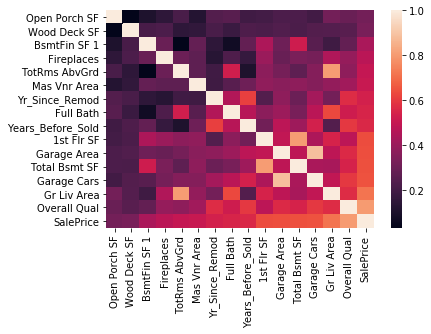

In [23]:
strong_corr = sorted_num_corr[sorted_num_corr > 0.3]
corr_map = transformed_data[strong_corr.index].corr().abs()
sns.heatmap(corr_map)

The following features appear to have a strong correlaion:
- `TotRms AbvGrnd` and `Gr Liv Area` 
- `Garage Area` and `Garage Cars`
- `1st Flr SF` and `Total Basement SF`

For the first two instances, `Gr Liv Area` and `Garage Area` are continuous in nature and capture more nuance than their correlating features. We will keep these two and drop the other feature columns.

As for the third instance of 1st floor and basement square footage correlating, we would expect these values to be very similar for all houses.


In [24]:
# keep the features with greater than 0.3 correlation (drop with less than 0.3 corr)
transformed_data = transformed_data.drop(sorted_num_corr[sorted_num_corr < 0.3].index, axis = 1)

# drop the feature columns with feature correlation
transformed_data = transformed_data.drop(['TotRms AbvGrd', 'Garage Cars'], axis = 1)

transformed_data.columns


Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Kitchen Qual',
       'Functional', 'Fireplaces', 'Garage Area', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'SalePrice', 'Years_Before_Sold',
       'Yr_Since_Remod'],
      dtype='object')

#### Numerical Feature Variation
We should remove any features with low variance as they don't meaningfully contribute to a model's predictive capability.

We will transform the numerical data by rescaling, set a variance cut-off value, and remove features that fall below the cut-off value. This variance cutoff value is another parameter that can be optimized.

In [25]:
num_feat_df = transformed_data.select_dtypes(include = (['float', 'integer']))
rescaled_num_data = (num_feat_df - num_feat_df.min()) / (num_feat_df.max() - num_feat_df.min())
sorted_vars = rescaled_num_data.var().sort_values()
sorted_vars

Total Bsmt SF        0.005004
BsmtFin SF 1         0.006351
1st Flr SF           0.007620
Wood Deck SF         0.007851
Open Porch SF        0.007959
Gr Liv Area          0.008735
SalePrice            0.011595
Mas Vnr Area         0.012261
Full Bath            0.019044
Garage Area          0.020811
Overall Qual         0.024461
Fireplaces           0.026187
Years_Before_Sold    0.049574
Yr_Since_Remod       0.120775
dtype: float64

Let's begin with keeping features with a variance of > 0.005, though this is the default cutoff at the dataset's current state. This cutoff can be adjusted as the dataset changes as we change the parameters.

In [26]:
transformed_data = transformed_data.drop(sorted_vars[sorted_vars < 0.005].index, axis = 1)
transformed_data.columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation',
       'BsmtFin SF 1', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'Kitchen Qual',
       'Functional', 'Fireplaces', 'Garage Area', 'Paved Drive',
       'Wood Deck SF', 'Open Porch SF', 'SalePrice', 'Years_Before_Sold',
       'Yr_Since_Remod'],
      dtype='object')

### Categorical Data Selection
Next, let's determine which of our features are nominal variables (from [this](https://s3.amazonaws.com/dq-content/307/data_description.txt) documentation) and consider whether to convert these to categorical. Consider:
- If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.
- Which categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category? This would be similar to a low variance numerical feature (no variability in the data for the model to capture).

In [27]:
## Create a list of all column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

How many of these feature columns are still in our dataset?

In [28]:
cols_for_cat = []
for col in nominal_features:
    if col in transformed_data:
        cols_for_cat.append(col)
        
cols_for_cat

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Heating',
 'Central Air']

Let's review each of these features and determine how to handle their data.
First we will look for categories with lots of unique values.
We will look at each feature and calculate the percentage of counts for the most common category. If the percentage of counts falls within a specific cutoff (we'll start with 95%) we will remove that feature column.


In [29]:
col_value_count = {}

for col in cols_for_cat:
    value_counts = transformed_data[col].value_counts()
    col_value_count[col] = value_counts
    
col_value_count    

{'MS Zoning': RL         2268
 RM          460
 FV          139
 RH           27
 C (all)      25
 A (agr)       2
 I (all)       2
 Name: MS Zoning, dtype: int64, 'Street': Pave    2911
 Grvl      12
 Name: Street, dtype: int64, 'Land Contour': Lvl    2628
 HLS     120
 Bnk     115
 Low      60
 Name: Land Contour, dtype: int64, 'Lot Config': Inside     2135
 Corner      510
 CulDSac     180
 FR2          85
 FR3          13
 Name: Lot Config, dtype: int64, 'Neighborhood': NAmes      443
 CollgCr    267
 OldTown    239
 Edwards    191
 Somerst    182
 Gilbert    165
 NridgHt    165
 Sawyer     151
 NWAmes     131
 SawyerW    125
 Mitchel    114
 BrkSide    107
 Crawfor    103
 IDOTRR      92
 Timber      71
 NoRidge     71
 StoneBr     51
 SWISU       48
 ClearCr     44
 MeadowV     37
 BrDale      30
 Blmngtn     28
 Veenker     24
 NPkVill     23
 Blueste     10
 Greens       8
 GrnHill      2
 Landmrk      1
 Name: Neighborhood, dtype: int64, 'Condition 1': Norm      2517
 Feedr   

None of these features have a large number of unique values. The `Neighborhood` feature has the largest number of unique values but location can have a huge impact on home sale prices so we should leave this feature in our model. 

We will next look at each feature and calculate the percentage of counts for the most common category. If that percentage of counts falls within a specific cutoff (we'll start with 95%) we will remove that feature column.


In [30]:
cat_cols_to_drop = []

for col in cols_for_cat:
    value_counts = transformed_data[col].value_counts()
    cat_percent = value_counts[0]/value_counts.sum()
    if cat_percent > .95:
        cat_cols_to_drop.append(col)
        
        
# dropping columns that fit our drop parameter of 95%
transformed_data = transformed_data.drop(cat_cols_to_drop, axis = 1)
    

We will lastly convert all text columns into the categorical data type

In [31]:
# Select just text columns and convert to categorical
text_cols = transformed_data.select_dtypes(include=['object'])

for col in text_cols:
    transformed_data[col] = transformed_data[col].astype('category')
    
# Create dummy columns and add back to the dataframe
transformed_data = pd.concat([
    transformed_data, 
    pd.get_dummies(transformed_data.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

In [32]:
# data check
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2923 entries, 0 to 2929
Columns: 177 entries, Overall Qual to Paved Drive_Y
dtypes: float64(4), int64(10), uint8(163)
memory usage: 807.8 KB


## Update Fuction Pipeline
We can now update our `select_features()` function to accept the dataframe, a correlation-cutoff value, a variance-cutoff value, and a category percentage cutoff.

In [33]:
#Creating a function named `transform_features()` that will clean and transform our dataset

def transform_features(data):
    # find null values and drop columns where >25% of data is missing
    null_values = data.isnull().sum()
    drop_missing_cols = null_values[(null_values > len(data)* .25)].sort_values()
    data = data.drop(drop_missing_cols.index, axis=1)
    
    # fill specific columns with values
    data['Mas Vnr Type'] = data['Mas Vnr Type'].fillna('None')
    data['Mas Vnr Area'] = data['Mas Vnr Area'].fillna(0)
    
    # selecting text columns and dropping columns with more than 20 missing values
    text_mv = data.select_dtypes(include = ['object']).isnull().sum()
    cols_to_drop = text_mv[text_mv >20].index
    data = data.drop(cols_to_drop, axis = 1)
    
    # dropping specific columns
    data = data.drop(data[['Lot Frontage', 'Garage Yr Blt']], axis = 1)
    
    # remove rows with missing values
    data = data.dropna()
    
    # transforming features and removing negative values and original columns
    data['Years_Before_Sold'] = data['Yr Sold'] - data['Year Built']
    data['Yr_Since_Remod'] = data['Yr Sold'] - data['Year Remod/Add']
    data = data.drop([1702, 2180, 2181], axis = 0)
    data = data.drop(['Year Built', 'Year Remod/Add' ], axis = 1)
    
    # Removing Features
    data = data.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type'], axis = 1)    
    
    return data



# Creating a function named `select_features()` 
# This will create our cleaned dataframe of selected data and accepts 3 cutoff parameters

def select_features(data, corr_cutoff = 0.3, var_cutoff = 0.005, cat_cutoff = 0.95):
    # selecting numerical features above a correlation_cutoff
    num_feat_df = data.select_dtypes(include = (['float', 'integer']))
    sorted_num_corr = num_feat_df.corr()['SalePrice'].abs().sort_values()
    data = data.drop(sorted_num_corr[sorted_num_corr < corr_cutoff].index, axis = 1)

    # drop the feature columns with feature correlation
    data = data.drop(['TotRms AbvGrd', 'Garage Cars'], axis = 1)
    
    # numerical feature variation calculation and selection of var_cutoff
    num_feat_df = data.select_dtypes(include = (['float', 'integer']))
    rescaled_num_data = (num_feat_df - num_feat_df.min()) / (num_feat_df.max() - num_feat_df.min())
    sorted_vars = rescaled_num_data.var().sort_values()
    data = data.drop(sorted_vars[sorted_vars < var_cutoff].index, axis = 1)
    
    # Categorical data selection
    # Create a list of all column names from documentation that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    # Selecting the categorical columns from our current dataset
    cols_for_cat = []
    for col in nominal_features:
        if col in data:
            cols_for_cat.append(col)
    
    # selecting columns with more than the cat_cutoff threshold (default is 95%) 
    cat_cols_to_drop = []
    for col in cols_for_cat:
        value_counts = data[col].value_counts()
        cat_percent = value_counts[0]/value_counts.sum()
        if cat_percent > cat_cutoff:
            cat_cols_to_drop.append(col)
    # dropping columns that fit our drop parameter of 95%
    data = data.drop(cat_cols_to_drop, axis = 1)
    
    # Convert text columns to categorical
    text_cols = data.select_dtypes(include=['object'])
    for col in text_cols:
        data[col] = data[col].astype('category')
    
    # Create dummy columns and add back to the dataframe
    data = pd.concat([data, pd.get_dummies(data.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return data
                      

# Creating a generic function named train_and_test() that, to begin, accepts a dataframe, splits the data to 
# 'train' and `test` sets, trains, fits, and tests the model, and returns the RMSE  value

def train_and_test(data):
    train = data[:1460]
    test = data[1460:]
    
    #select all numerical columns
    num_train = train.select_dtypes(include = ['float', 'integer'])
    num_test = test.select_dtypes(include = ['float', 'integer'])
    
    # creating a list of column names to use as features, minus the `SalePrice` column
    features = num_train.columns.drop('SalePrice')
    
    # Instantiate a LinearRegression Model
    lr = LinearRegression()
    # fit the model
    lr.fit(train[features], train['SalePrice'])
    
    # train the model
    train_predictions = lr.predict(train[features])
    # test the model
    test_predictions = lr.predict(test[features])
    
    # Calculate error as RMSE
    test_rmse = mean_squared_error(test['SalePrice'], test_predictions)**(1/2)
    
    return test_rmse

# Applying pipeline functions in sequence with a raw dataset:
# and some tinkering with the parameters

data = pd.read_csv("AmesHousing.tsv", delimiter = '\t')
transformed_data = transform_features(data)
selected_data = select_features(transformed_data, 0.1, 0.007, .95)
rmse = train_and_test(selected_data)

rmse

30073.56881201189

## Coding the Model
When iterating on different features, using simple validation is prudent. We will add a parameter named `k` that controls the type of cross validation will occur. We will make cases for when `k` = 1, `k` = 2, and `k` = any whole number more than 2.

When `k` = 1, we will be using a train-test model with holdout validation consisting of half of the data for training and half of the data for testing. No cross-testing, just a quick general idea of how the model is working. This will be the default value for `k`.

When `k` = 2, we will use a holdout validation consisting of, again, half of the data for training and half of the data for testing. This time, we will perform cross validation and therefore will take an average of the resultting RMSE values as the function output.

When `k` is >2, k will represent the number of divisions of data and therefore also the number of cross validations. 

In [34]:
#Creating a function named `transform_features()` that will clean and transform our dataset

def transform_features(data):
    # find null values and drop columns where >25% of data is missing
    null_values = data.isnull().sum()
    drop_missing_cols = null_values[(null_values > len(data)* .25)].sort_values()
    data = data.drop(drop_missing_cols.index, axis=1)
    
    # fill specific columns with values
    data['Mas Vnr Type'] = data['Mas Vnr Type'].fillna('None')
    data['Mas Vnr Area'] = data['Mas Vnr Area'].fillna(0)
    
    # selecting text columns and dropping columns with more than 20 missing values
    text_mv = data.select_dtypes(include = ['object']).isnull().sum()
    cols_to_drop = text_mv[text_mv >20].index
    data = data.drop(cols_to_drop, axis = 1)
    
    # dropping specific columns
    data = data.drop(data[['Lot Frontage', 'Garage Yr Blt']], axis = 1)
    
    # remove rows with missing values
    data = data.dropna()
    
    # transforming features and removing negative values and original columns
    data['Years_Before_Sold'] = data['Yr Sold'] - data['Year Built']
    data['Yr_Since_Remod'] = data['Yr Sold'] - data['Year Remod/Add']
    data = data.drop([1702, 2180, 2181], axis = 0)
    data = data.drop(['Year Built', 'Year Remod/Add' ], axis = 1)
    
    # Removing Features
    data = data.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type'], axis = 1)    
    
    return data



# Creating a function named `select_features()` 
# This will create our cleaned dataframe of selected data and accepts 3 cutoff parameters

def select_features(data, corr_cutoff = 0.3, var_cutoff = 0.005, cat_cutoff = 0.95):
    # selecting numerical features above a correlation_cutoff
    num_feat_df = data.select_dtypes(include = (['float', 'integer']))
    sorted_num_corr = num_feat_df.corr()['SalePrice'].abs().sort_values()
    data = data.drop(sorted_num_corr[sorted_num_corr < corr_cutoff].index, axis = 1)

    # drop the feature columns with observed feature correlation
    data = data.drop(['TotRms AbvGrd', 'Garage Cars'], axis = 1)
    
    # numerical feature variation calculation and selection of var_cutoff
    num_feat_df = data.select_dtypes(include = (['float', 'integer']))
    rescaled_num_data = (num_feat_df - num_feat_df.min()) / (num_feat_df.max() - num_feat_df.min())
    sorted_vars = rescaled_num_data.var().sort_values()
    data = data.drop(sorted_vars[sorted_vars < var_cutoff].index, axis = 1)
    
    # Categorical data selection
    # Create a list of all column names from documentation that are *meant* to be categorical
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    # Selecting the categorical columns from our current dataset
    cols_for_cat = []
    for col in nominal_features:
        if col in data:
            cols_for_cat.append(col)
    
    # selecting columns with more than the cat_cutoff threshold (default is 95%) 
    cat_cols_to_drop = []
    for col in cols_for_cat:
        value_counts = data[col].value_counts()
        cat_percent = value_counts[0]/value_counts.sum()
        if cat_percent > cat_cutoff:
            cat_cols_to_drop.append(col)
    # dropping columns that fit our drop parameter of 95%
    data = data.drop(cat_cols_to_drop, axis = 1)
    
    # Convert text columns to categorical
    text_cols = data.select_dtypes(include=['object'])
    for col in text_cols:
        data[col] = data[col].astype('category')
    
    # Create dummy columns and add back to the dataframe
    data = pd.concat([data, pd.get_dummies(data.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return data

def train_and_test(data, k=1):    
    
    # creating a list of column names to use as features, minus the `SalePrice` column
    features = data.columns.drop('SalePrice')
    
    # Instantiate a LinearRegression Model
    lr = LinearRegression()
    
    if k == 1:
        # Randomize the data
        randomized_list = np.random.permutation(data.index)
        data = data.reindex(randomized_list)
    
        train = data[:1460].copy()
        test = data[1460:].copy()
    
        # fit the model
        lr.fit(train[features], train['SalePrice'])
    
        # train the model
        train_predictions = lr.predict(train[features])
        # test the model
        test_predictions = lr.predict(test[features])
    
        # Calculate error as RMSE
        test_rmse = mean_squared_error(test['SalePrice'], test_predictions)**(1/2)
    
        return test_rmse
    
    if k == 2:
        # Randomize the data
        randomized_list = np.random.permutation(data.index)
        data = data.reindex(randomized_list)
        
        # Split the data into two sets, and swap for validation
        train_1 = data[:1460].copy()
        test_1 = data[1460:].copy()
        train_2 = test_1
        test_2 = train_1
                   
        # fit the 1st model
        lr.fit(train_1[features], train_1['SalePrice'])
    
        # train the 1st model
        train_1_predictions = lr.predict(train_1[features])
        
        # test the 1st model
        test_1_predictions = lr.predict(test_1[features])
    
        # fit the 2nd model
        lr.fit(train_2[features], train_2['SalePrice'])
    
        # train the 2nd model
        train_2_predictions = lr.predict(train_2[features])
        
        # test the 1st model
        test_2_predictions = lr.predict(test_2[features])
        
        
        # Calculate error as RMSE
        test_1_rmse = mean_squared_error(test_1['SalePrice'], test_1_predictions)**(1/2)
        test_2_rmse = mean_squared_error(test_2['SalePrice'], test_2_predictions)**(1/2)
        avg_rmse = np.mean([test_1_rmse, test_2_rmse])
    
        return avg_rmse
    
    else:
        kf = KFold(n_splits = k, shuffle = True, random_state = None)
        mses = cross_val_score(lr, data[features], data['SalePrice'], scoring = 'neg_mean_squared_error', cv = kf)
        rmses = np.sqrt(np.absolute(mses))
        print("rmses", rmses)
        avg_rmse = np.mean(rmses)
        
        return avg_rmse
        
    
    

# Applying pipeline functions in sequence with a raw dataset:
# and some tinkering with the parameters

data = pd.read_csv("AmesHousing.tsv", delimiter = '\t')
transformed_data = transform_features(data)
selected_data = select_features(transformed_data, 0.1, 0.007, .95)
rmse = train_and_test(selected_data, 10)

rmse    

rmses [23926.58158648 23664.48694183 41292.48280602 34465.62062863
 23592.94483592 22278.26122974 21650.15335419 23864.62882597
 21114.77411435 29387.0726827 ]


26523.700700581852

With parameters of:
- corr_cutoff = 0.3 
- var_cutoff = 0.005 
- cat_cutoff = 0.95
- k = 10

The average RMSE is hovering around 26700. The lowest RMSE observed was around 21000 and the highest was around 41000.

## Next steps

This model could be further improved by continuing to improve feature engineering steps. Including:
- iterating/optimizing on `select_features()` parameters and the number of K-folds
- exploring other impactful ways to select features

